# 0. Setup

In [10]:
import pathlib
import os
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
# Load preprocessed loan data
def load_loan_data():
    ROOT_PATH = pathlib.Path().resolve().parent
    raw_data_path = os.path.join(ROOT_PATH, 'raw_data', 'Loan_Default.csv')
    print(f"🔍 Checking for file at path: {raw_data_path}")

    if os.path.exists(raw_data_path):
        data = pd.read_csv(raw_data_path)
        print("✅ Data loaded successfully")
        return data
    else:
        raise FileNotFoundError(f"The file {raw_data_path} does not exist. Please check the path.")

In [12]:
# Load data
data = load_loan_data()

data.tail()

🔍 Checking for file at path: /Users/giliamo/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv
✅ Data loaded successfully


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0
148669,173559,2019,cf,Female,nopre,type1,p3,l1,nopc,nob/c,...,CIB,830,CIB,45-54,not_inst,72.849462,North,direct,0,44.0


# 1. Explore Suspicious Variables

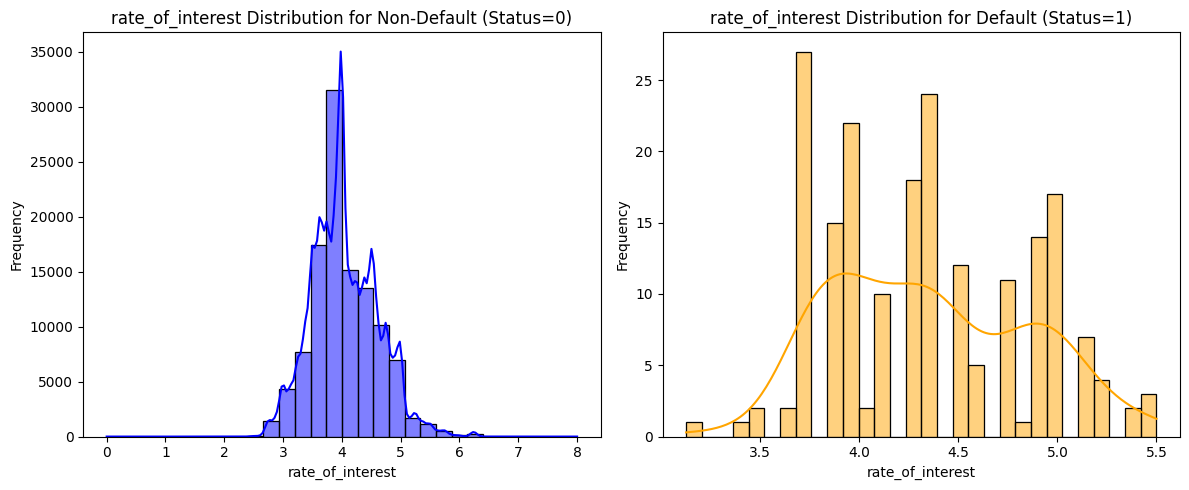

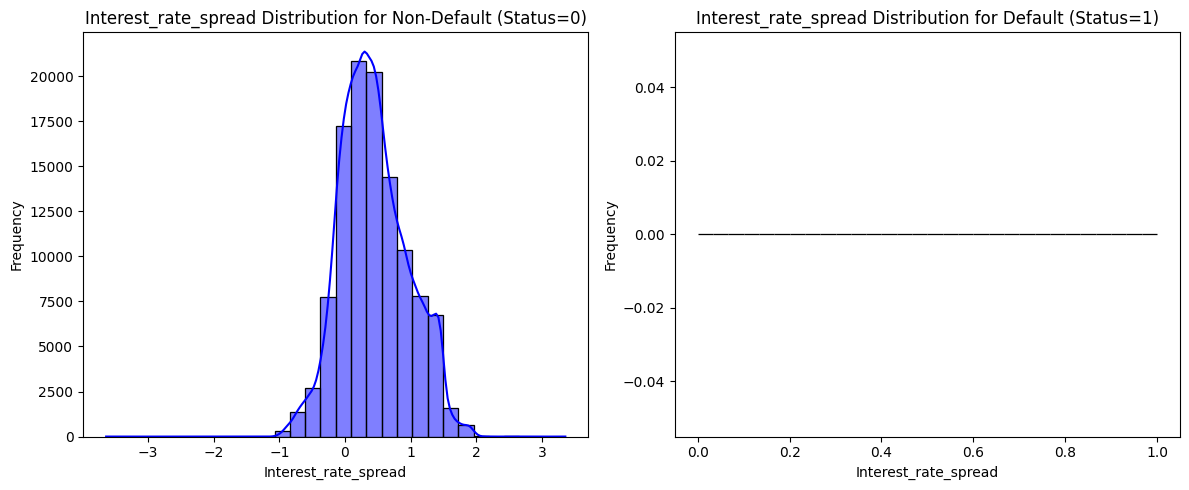

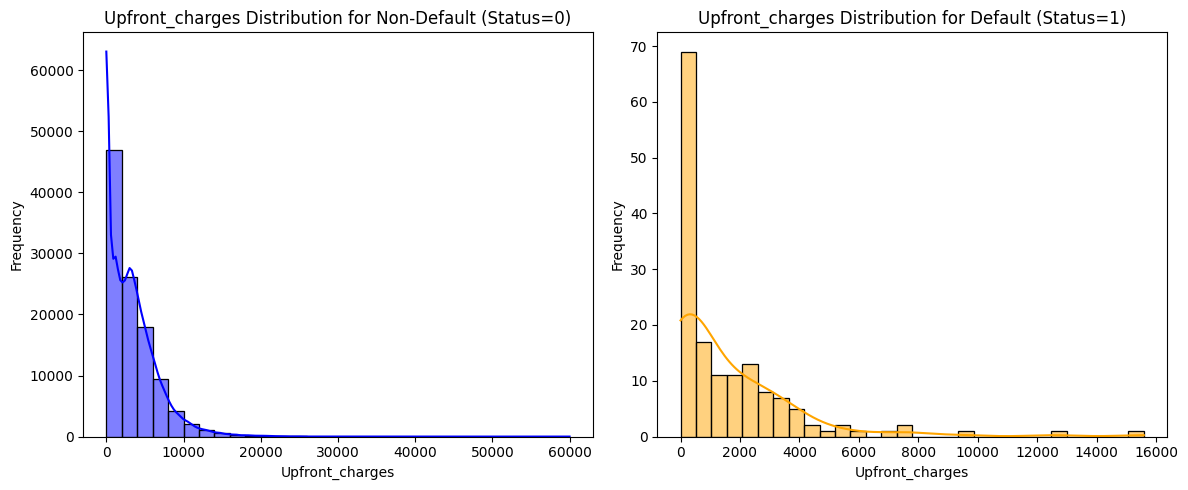

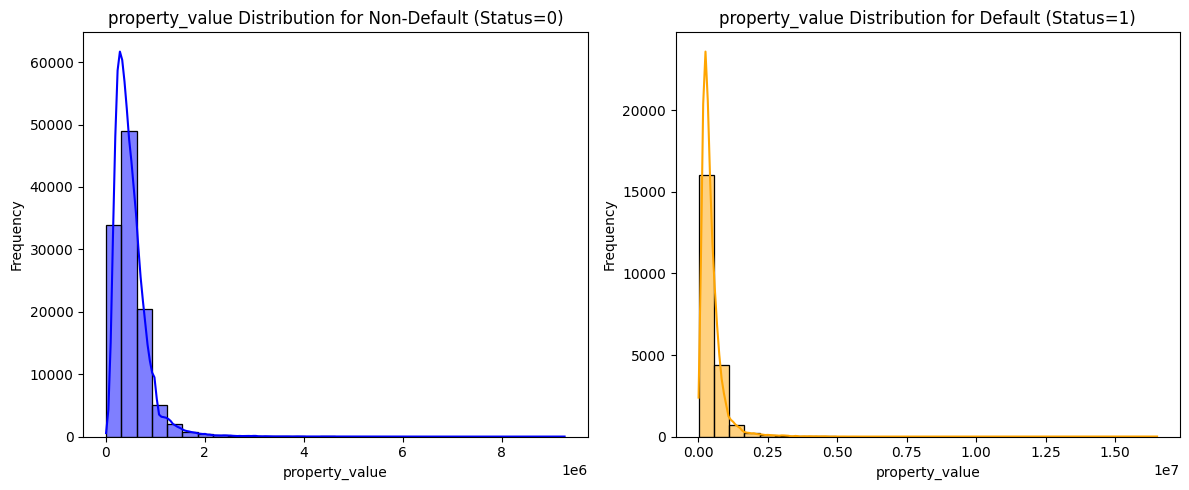

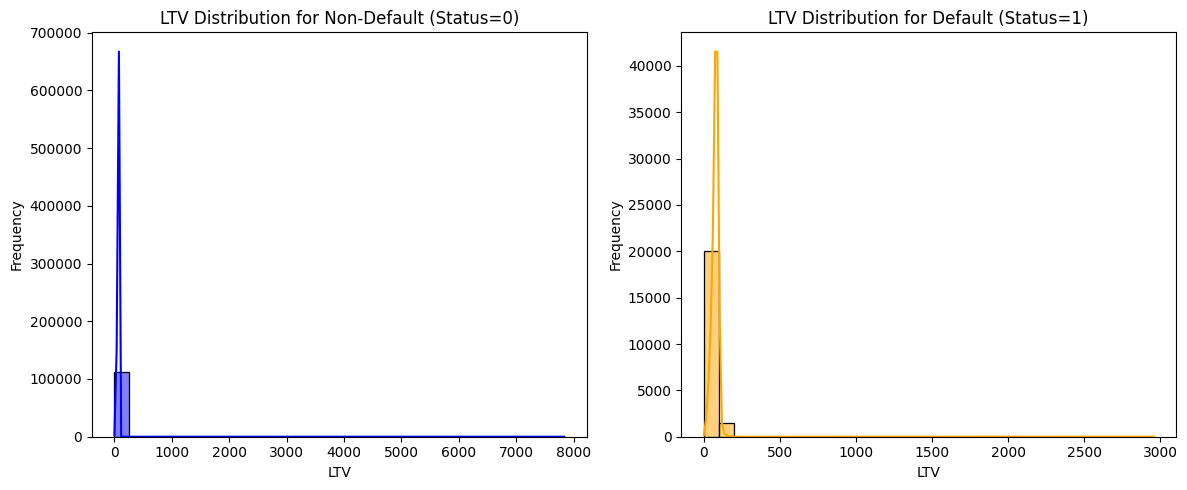

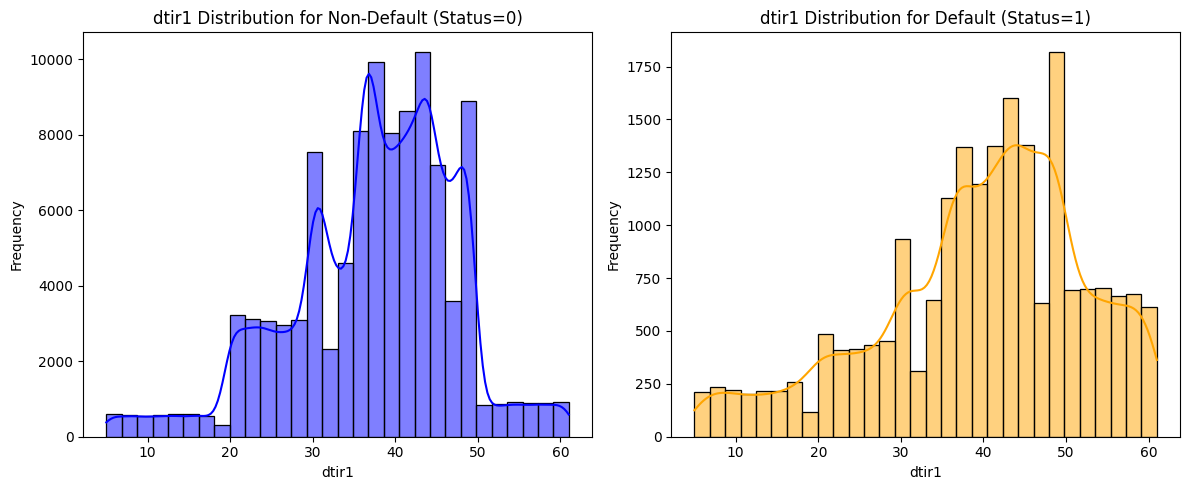

In [ ]:
# List of KPIs to analyze
kpis_to_check = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']

# Loop through each KPI to plot distributions for Status=0 and Status=1
for kpi in kpis_to_check:
    plt.figure(figsize=(12, 5))

    # Plot distribution for Non-Default Status (0)
    plt.subplot(1, 2, 1)
    sns.histplot(data[data['Status'] == 0][kpi], kde=True, bins=30, color='blue')
    plt.title(f'{kpi} Distribution for Non-Default (Status=0)')
    plt.xlabel(kpi)
    plt.ylabel('Frequency')

    # Plot distribution for Default Status (1)
    plt.subplot(1, 2, 2)
    sns.histplot(data[data['Status'] == 1][kpi], kde=True, bins=30, color='orange')
    plt.title(f'{kpi} Distribution for Default (Status=1)')
    plt.xlabel(kpi)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [38]:
# Initialize a dictionary for results
missing_percentage = {
    'KPI': [],
    'Missing_Percentage_Status_0': [],
    'Missing_Percentage_Status_1': []
}

# Calculate the percentage of missing values for each KPI, separated by Status 0 and 1
for kpi in kpis_to_check:
    missing_percentage['KPI'].append(kpi)
    missing_percentage['Missing_Percentage_Status_0'].append(data[data['Status'] == 0][kpi].isnull().mean() * 100)
    missing_percentage['Missing_Percentage_Status_1'].append(data[data['Status'] == 1][kpi].isnull().mean() * 100)

# Create a DataFrame from the dictionary and sort it by Missing_Percentage_Status_1 in descending order
missing_percentage_df = pd.DataFrame(missing_percentage).sort_values(by='Missing_Percentage_Status_1', ascending=False)

print("Percentage of missing values for Status 0 and 1")
print(missing_percentage_df)

Percentage of missing values for Status 0 and 1
                    KPI  Missing_Percentage_Status_0  \
1  Interest_rate_spread                     0.000000   
2       Upfront_charges                     2.817077   
0      rate_of_interest                     0.000000   
5                 dtir1                     6.972177   
3        property_value                     0.001785   
4                   LTV                     0.001785   

   Missing_Percentage_Status_1  
1                   100.000000  
2                    99.582412  
0                    99.454134  
5                    44.515407  
3                    41.201998  
4                    41.201998  


**Observations:**
1. Leakage Potential: I've observed that the variables `rate_of_interest`, `Interest_rate_spread`, and `Upfront_charges` have an extremely high percentage of missing values when `Status = 1` (loan defaults), close to 100%. This suggests that these variables may only apply to approved loans, potentially introducing leakage if I include them in the prediction model.
2. Information Imbalance: Given the lack of values for these features in default cases, they inherently differentiate between approved and defaulted loans. Including them could cause the model to rely on this imbalance, "leaking" information that wouldn't be available in a real predictive scenario.
3. Feature Strategy: To prevent this leakage, I’ll remove these variables from the feature set in the default prediction model. Instead, I could use them in a secondary model (e.g., a linear regression) to calculate interest-related metrics, but only if the first model approves the loan.

The three variables— `property_value`, `LTV`, and `dtir1` —show suspiciously high missing rates specifically when `Status = 1`, suggesting a potential pattern or data quality issue; further investigation is warranted to understand if these values are systematically unavailable for certain cases.

In [23]:
# Filter data for rows where Status is 1
status_1_data = data[data['Status'] == 1]

# Find rows with missing values in any of the three variables
missing_any_count = status_1_data[['property_value', 'LTV', 'dtir1']].isnull().any(axis=1).sum()

# Filter for rows where all three variables are missing
missing_all_count = status_1_data[['property_value', 'LTV', 'dtir1']].isnull().all(axis=1).sum()

# Calculate percentage of rows with missing values in all three among those with any missing
percentage_missing_all = (missing_all_count / missing_any_count) * 100

print(f"Percentage of rows with missing values in all three variables (property_value, LTV, and dtir1) "
      f"out of rows with at least one missing value: {percentage_missing_all:.2f}%")

Percentage of rows with missing values in all three variables (property_value, LTV, and dtir1) out of rows with at least one missing value: 92.56%


**Assumptions:**
1. No Collateral Requirement: Missing values for `property_value`, `LTV`, and `dtir1` might indicate loans without property collateral, where these metrics are unnecessary.
2. Loan Type: Certain types of loans (e.g., personal or short-term loans) may not require income or collateral verification, leaving these variables blank.
3. Special Applicant Conditions: Missing data may reflect specific applicant profiles, like high-creditworthiness individuals, where full verification is bypassed.

In [ ]:
# 1. Check if loans without collateral requirement ('Secured_by' is NaN or a specific value) align with missing values in `property_value`, `LTV`, and `dtir1`.
collateral_check = data[
    (data['Status'] == 1) &
    (data[['property_value', 'LTV', 'dtir1']].isnull().all(axis=1))
]

collateral_summary = collateral_check['Secured_by'].value_counts(dropna=False)
print("Collateral Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(collateral_summary)

# 2. Analyze loan types for those with missing values in `property_value`, `LTV`, and `dtir1`.
loan_type_summary = collateral_check['loan_type'].value_counts(dropna=False)
loan_purpose_summary = collateral_check['loan_purpose'].value_counts(dropna=False)
print("\nLoan Type Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(loan_type_summary)
print("\nLoan Purpose Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(loan_purpose_summary)

# 3. Check if Credit Worthiness or advanced approval affects the missing values in `property_value`, `LTV`, and `dtir1`.
creditworthiness_summary = collateral_check['Credit_Worthiness'].value_counts(dropna=False)
approv_in_adv_summary = collateral_check['approv_in_adv'].value_counts(dropna=False)
print("\nCredit Worthiness Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(creditworthiness_summary)
print("\nApproval in Advance Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(approv_in_adv_summary)

Collateral Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
Secured_by
home    15096
Name: count, dtype: int64

Loan Type Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
loan_type
type1    11051
type2     2295
type3     1750
Name: count, dtype: int64

Loan Purpose Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
loan_purpose
p4     5397
p3     4909
p1     4433
p2      340
NaN      17
Name: count, dtype: int64

Credit Worthiness Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
Credit_Worthiness
l1    14236
l2      860
Name: count, dtype: int64

Approval in Advance Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
approv_in_adv
nopre    12921
pre       2078
NaN         97
Name: count, dtype: int64


**Observation:**
Rows with missing values in `property_value`, `LTV`, and `dtir1` when `Status = 1` appear to have specific patterns:
1. Collateral Type: All missing entries are secured by "home," suggesting a simplified data requirement for these home-secured loans.
2. Loan Type and Purpose: Most missing values belong to `loan_type` "type1" and `loan_purpose` "p4," hinting that loans with these specifications might omit certain financial details.
3. Creditworthiness and Pre-Approval: The majority of these rows have high creditworthiness (`l1`) and lack pre-approval (`nopre`), suggesting that these loans might bypass extensive verification.
---
**Next Steps:**
- Given these patterns, I’ll consider removing these variables from the model, as they may introduce bias. (The variables are dropped in the preprocessor.)
- Alternatively, I could use these variables selectively, keeping them only for relevant loan types, to maintain model accuracy without data leakage.

# 2. Explore Remaining Variables

In [39]:
# List of variables to exclude from the missing summary
exclude_vars = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']

# Calculate missing values and percentages
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Missing values summary excluding specified variables
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
}).drop(exclude_vars, errors='ignore')

# Filter to show only columns with at least 1 missing value and sort
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

print(missing_summary)

                           Missing Values  Percentage (%)
income                               9150        6.154571
loan_limit                           3344        2.249277
approv_in_adv                         908        0.610749
age                                   200        0.134526
submission_of_application             200        0.134526
loan_purpose                          134        0.090133
Neg_ammortization                     121        0.081388
term                                   41        0.027578


### 2.1 Income

In [40]:
# Check for patterns in missing income values
missing_income_data = data[data['income'].isnull()]

# Display summary of relevant categorical variables when income is missing
categorical_summary = missing_income_data.describe(include='object')
print("Categorical Summary for rows with missing income:")
print(categorical_summary)

# Display summary of relevant numerical variables when income is missing
numerical_summary = missing_income_data.describe()
print("\nNumerical Summary for rows with missing income:")
print(numerical_summary)

Categorical Summary for rows with missing income:
       loan_limit Gender approv_in_adv loan_type loan_purpose  \
count        9054   9150          9119      9150         9142   
unique          2      4             2         3            4   
top            cf  Joint         nopre     type3           p4   
freq         8178   2970          8196      5403         8897   

       Credit_Worthiness open_credit business_or_commercial Neg_ammortization  \
count               9150        9150                   9150              9149   
unique                 2           1                      2                 2   
top                   l1        nopc                  nob/c           not_neg   
freq                9003        9150                   5544              8700   

       interest_only  ... construction_type occupancy_type Secured_by  \
count           9150  ...              9150           9150       9150   
unique             2  ...                 2              3          2   

**Observation:**

The missing income values are associated with a specific distribution across several categorical variables. Notably, these rows predominantly feature loans that are not pre-approved (`nopre`), are secured by `home`, and are often classified under `type3` loan type and purpose `p4`. Additionally, a large portion shows a high `Credit_Worthiness` rating of `l1` and belongs to applicants from the `North` region. These patterns suggest that missing income might relate to particular loan or customer characteristics.

**Assumptions:**
1. Certain Loan Types: Some loans may have been approved without knowing the applicant's income, relying instead on other securities or a co-signer to back the loan.
2. Specific Credit Types: These missing income entries could be linked to particular types of loans, such as commercial loans, where personal income may not be required.
3. Unique Customer Profiles: These loans could belong to customers with specific profiles for whom detailed income data was either unavailable or not required.

In [32]:
# Filter rows with missing income
missing_income_data = data[data['income'].isnull()]

# Step 1: Summary of key variables for rows with missing income
print("Summary for rows with missing income:")
print(missing_income_data[['loan_type', 'Credit_Worthiness', 'Secured_by', 'business_or_commercial']].describe(include='all'))

# Step 2: Segment dataset based on income availability
with_income_data = data[data['income'].notnull()]
without_income_data = data[data['income'].isnull()]

# Step 3: Calculate proportions for relevant variables in both segments
def calculate_proportions(df, column):
    return df[column].value_counts(normalize=True) * 100

# Calculate and compare distributions for 'loan_type' and 'Credit_Worthiness'
print("\nProportion of loan_type for rows WITH income:")
print(calculate_proportions(with_income_data, 'loan_type'))

print("\nProportion of loan_type for rows WITHOUT income:")
print(calculate_proportions(without_income_data, 'loan_type'))

print("\nProportion of Credit_Worthiness for rows WITH income:")
print(calculate_proportions(with_income_data, 'Credit_Worthiness'))

print("\nProportion of Credit_Worthiness for rows WITHOUT income:")
print(calculate_proportions(without_income_data, 'Credit_Worthiness'))

# Step 4: Check specific profiles, such as 'business_or_commercial'
print("\nProportion of 'business_or_commercial' for rows WITHOUT income:")
print(calculate_proportions(without_income_data, 'business_or_commercial'))

Summary for rows with missing income:
       loan_type Credit_Worthiness Secured_by business_or_commercial
count       9150              9150       9150                   9150
unique         3                 2          2                      2
top        type3                l1       home                  nob/c
freq        5403              9003       9147                   5544

Proportion of loan_type for rows WITH income:
loan_type
type1    81.014908
type2    12.296445
type3     6.688647
Name: proportion, dtype: float64

Proportion of loan_type for rows WITHOUT income:
loan_type
type3    59.049180
type2    39.409836
type1     1.540984
Name: proportion, dtype: float64

Proportion of Credit_Worthiness for rows WITH income:
Credit_Worthiness
l1    95.571244
l2     4.428756
Name: proportion, dtype: float64

Proportion of Credit_Worthiness for rows WITHOUT income:
Credit_Worthiness
l1    98.393443
l2     1.606557
Name: proportion, dtype: float64

Proportion of 'business_or_commercial' f

**Observations and Next Steps for Handling Missing Income Data:**
1. Verify Pattern Consistency: It appears that loans with high creditworthiness (Credit Worthiness "l1") often lack income data, possibly due to a reduced risk assessment requirement. I will further investigate if all loans with missing income data have this "l1" creditworthiness to confirm this pattern.
2. Feature Engineering Opportunity: Based on this observation, I can create a new indicator feature that flags cases where Credit Worthiness is "l1" and income data is missing. This feature may capture relevant risk information without relying directly on income values.
3. Handling in Modeling: If confirmed, I may choose to treat missing income values for "l1" cases differently, perhaps filling them with a placeholder or marking them as “not needed.” This approach allows the model to interpret this as a specific risk-related signal rather than a missing value.
4. Consider Excluding Income Data: If Credit Worthiness and Loan Type can sufficiently capture risk without income information, I could remove income data for "l1" cases to avoid redundancy and potential data leakage. This could simplify the model and improve interpretability.

In [ ]:
#Step 1
# Filter rows with missing income
missing_income_data = data[data['income'].isnull()]

# Calculate the proportion of Credit Worthiness levels in rows with missing income
credit_worthiness_proportion = missing_income_data['Credit_Worthiness'].value_counts(normalize=True) * 100

# Display the results
print("Proportion of Credit Worthiness levels for rows with missing income:")
print(credit_worthiness_proportion)

Proportion of Credit Worthiness levels for rows with missing income:
Credit_Worthiness
l1    98.393443
l2     1.606557
Name: proportion, dtype: float64


In [34]:
#Step 2: Check for Additional Factors or Correlated Features
# Analyze 'loan_type' proportions in rows with missing income
loan_type_missing_income = missing_income_data['loan_type'].value_counts(normalize=True) * 100
print("Proportion of loan_type for rows WITH missing income:")
print(loan_type_missing_income)

# Analyze 'loan_type' proportions in rows with income
loan_type_with_income = data[data['income'].notnull()]['loan_type'].value_counts(normalize=True) * 100
print("\nProportion of loan_type for rows WITHOUT missing income:")
print(loan_type_with_income)

# Analyze 'business_or_commercial' proportions in rows with missing income
business_commercial_missing_income = missing_income_data['business_or_commercial'].value_counts(normalize=True) * 100
print("\nProportion of business_or_commercial for rows WITH missing income:")
print(business_commercial_missing_income)

# Analyze 'business_or_commercial' proportions in rows with income
business_commercial_with_income = data[data['income'].notnull()]['business_or_commercial'].value_counts(normalize=True) * 100
print("\nProportion of business_or_commercial for rows WITHOUT missing income:")
print(business_commercial_with_income)

Proportion of loan_type for rows WITH missing income:
loan_type
type3    59.049180
type2    39.409836
type1     1.540984
Name: proportion, dtype: float64

Proportion of loan_type for rows WITHOUT missing income:
loan_type
type1    81.014908
type2    12.296445
type3     6.688647
Name: proportion, dtype: float64

Proportion of business_or_commercial for rows WITH missing income:
business_or_commercial
nob/c    60.590164
b/c      39.409836
Name: proportion, dtype: float64

Proportion of business_or_commercial for rows WITHOUT missing income:
business_or_commercial
nob/c    87.703555
b/c      12.296445
Name: proportion, dtype: float64


# 1. Feature Fine Tuning

### Create interest_income_ratio

The intention behind creating the `interest_income_ratio` feature is to quantify the portion of the borrower’s income that is dedicated to interest payments. This metric helps to assess the financial burden of the loan on the borrower, which could indicate higher risk levels for those with a significant share of their income going towards interest. By incorporating this ratio, we aim to improve the model's ability to predict loan defaults by capturing an important aspect of financial strain.

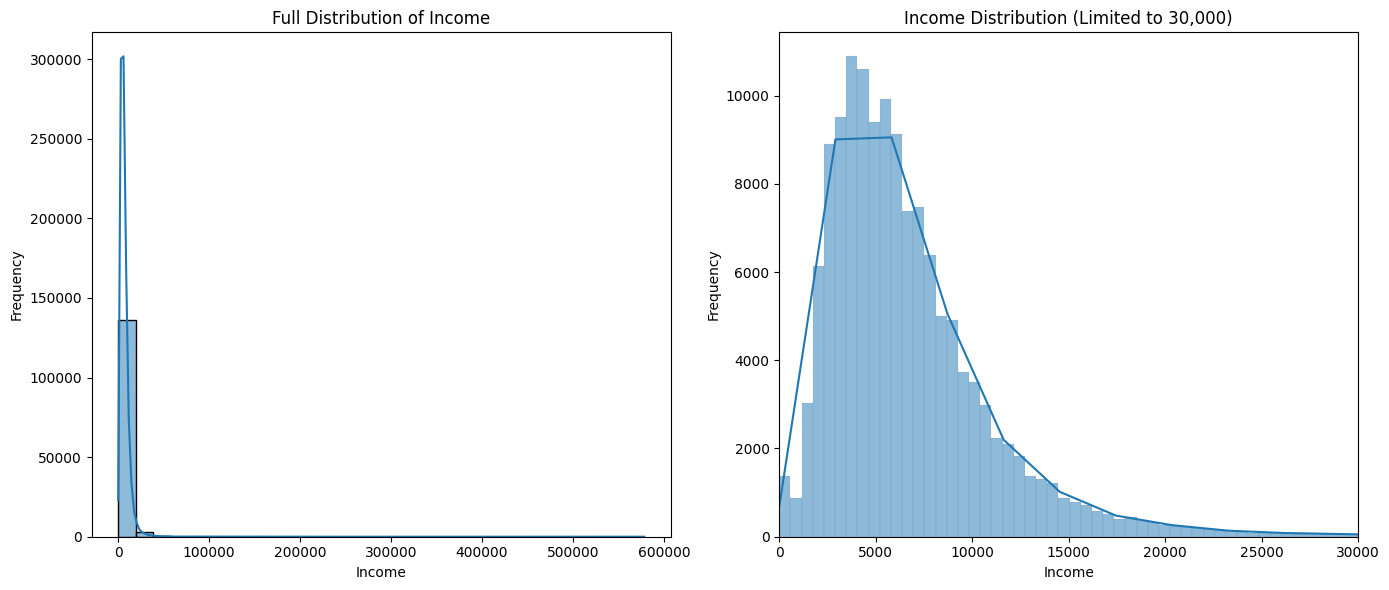

In [5]:
# Set up the subplot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full income distribution
sns.histplot(data['income'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Full Distribution of Income")
axes[0].set_xlabel("Income")
axes[0].set_ylabel("Frequency")

# Income distribution with x-axis limited to 30,000
sns.histplot(data['income'], bins=1000, kde=True, ax=axes[1])
axes[1].set_title("Income Distribution (Limited to 30,000)")
axes[1].set_xlabel("Income")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 30000)  # Set x-axis limit to 30,000

plt.tight_layout()
plt.show()

In [6]:
# Calculate `interest_income_ratio` and set to 0 where `income` is zero
data['interest_income_ratio'] = np.where(
    data['income'] > 0,  # Only calculate for positive income values
    (data['rate_of_interest'] * data['loan_amount']) / data['income'],
    0  # Set to 0 for rows with income = 0
)

In [7]:
# Select the top 10 highest interest_income_ratio values with corresponding columns
top_10_ratios = data.nlargest(10, 'interest_income_ratio')[['interest_income_ratio', 'rate_of_interest', 'loan_amount', 'income', 'Status']]

# Display the top 10 values
print(top_10_ratios)

        interest_income_ratio  rate_of_interest  loan_amount  income  Status
43079            18750.520833             4.625       486500   120.0       0
97078            18750.520833             4.625       486500   120.0       0
102942            6231.640625             5.375       556500   480.0       0
55968             2965.625000             4.875       766500  1260.0       0
54421             2409.062500             4.875       296500   600.0       0
71495             2054.092262             4.750       726500  1680.0       0
13604             2046.093750             4.500       436500   960.0       0
106473            1860.085227             5.625       436500  1320.0       0
88927             1823.708333             5.190       126500   360.0       0
81221             1801.078125             4.990       346500   960.0       0


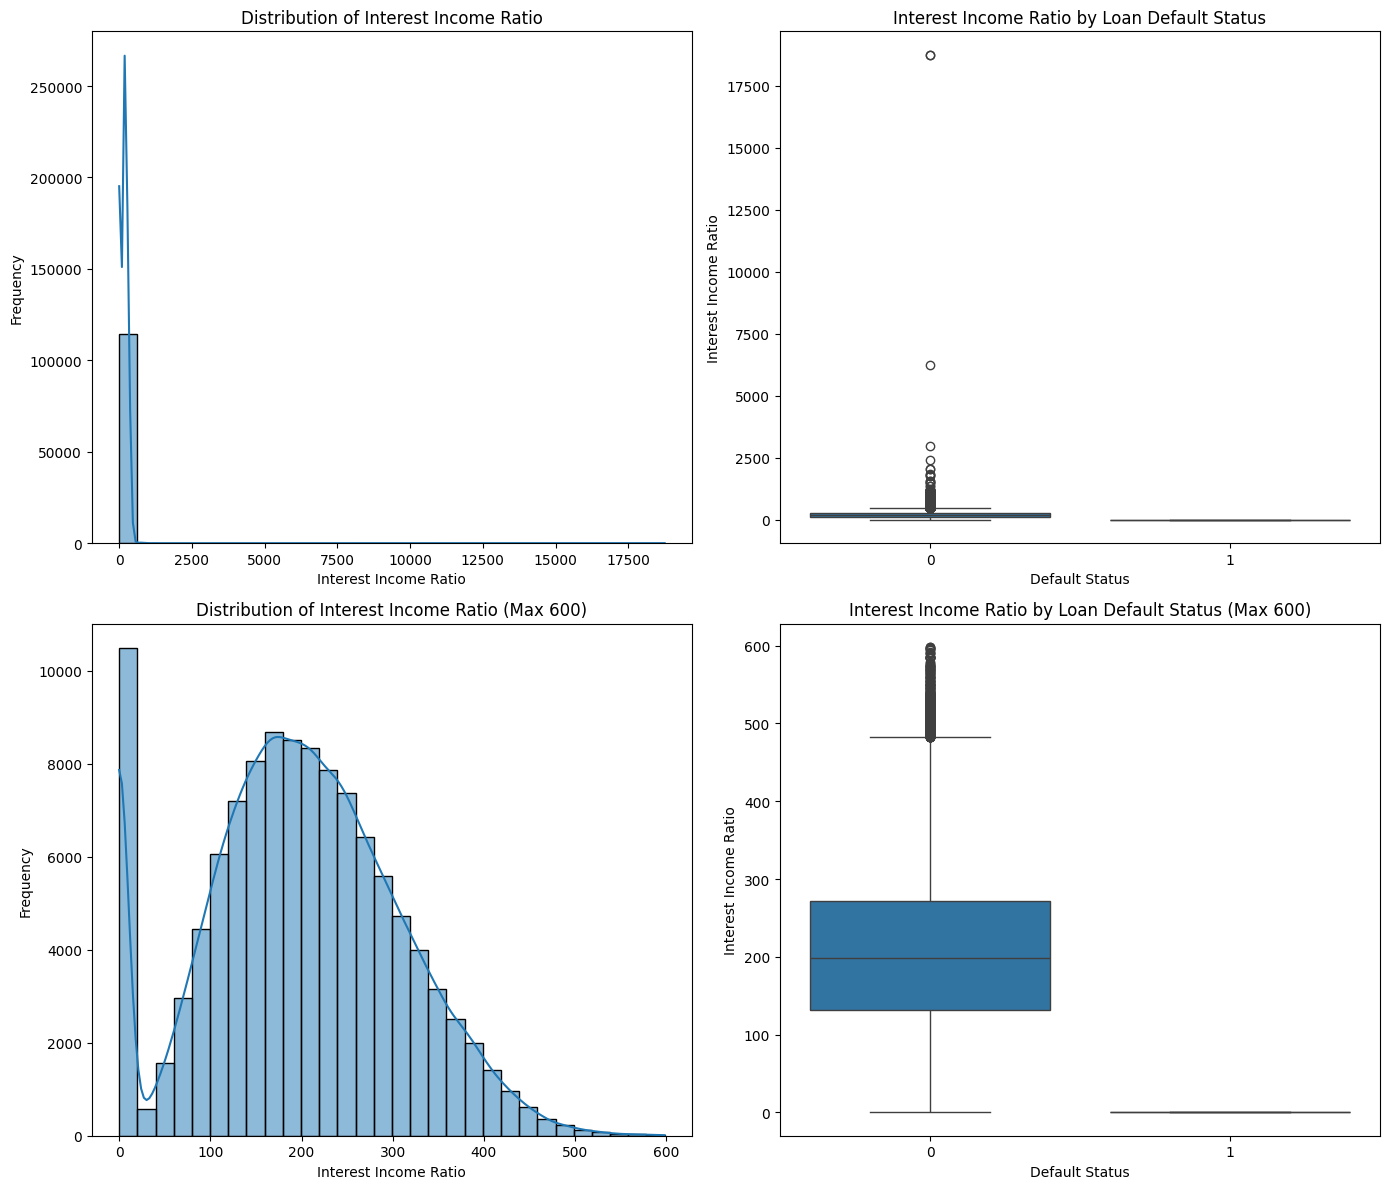

In [8]:
# Set up the subplot grid with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original distribution of interest_income_ratio
sns.histplot(data['interest_income_ratio'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Interest Income Ratio")
axes[0, 0].set_xlabel("Interest Income Ratio")
axes[0, 0].set_ylabel("Frequency")

# Original boxplot of interest_income_ratio by Status
sns.boxplot(x='Status', y='interest_income_ratio', data=data, ax=axes[0, 1])
axes[0, 1].set_title("Interest Income Ratio by Loan Default Status")
axes[0, 1].set_xlabel("Default Status")
axes[0, 1].set_ylabel("Interest Income Ratio")

# Limited distribution of interest_income_ratio (max 600)
sns.histplot(data[data['interest_income_ratio'] <= 600]['interest_income_ratio'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Interest Income Ratio (Max 600)")
axes[1, 0].set_xlabel("Interest Income Ratio")
axes[1, 0].set_ylabel("Frequency")

# Limited boxplot of interest_income_ratio by Status (max 600)
sns.boxplot(x='Status', y='interest_income_ratio', data=data[data['interest_income_ratio'] <= 600], ax=axes[1, 1])
axes[1, 1].set_title("Interest Income Ratio by Loan Default Status (Max 600)")
axes[1, 1].set_xlabel("Default Status")
axes[1, 1].set_ylabel("Interest Income Ratio")

plt.tight_layout()
plt.show()

### Drop Columns

Goal: Identify pairs of features with high correlation (e.g., correlation > 0.85). If two features are highly correlated, keeping both may not add value.

In [9]:
# Calculate absolute correlation matrix for numeric features
corr_matrix = data.select_dtypes(include=[np.number]).corr().abs()

# Extract pairs of highly correlated features
high_corr_pairs = [
    (i, j, corr_matrix.loc[i, j]) for i in corr_matrix.columns for j in corr_matrix.columns
    if i != j and corr_matrix.loc[i, j] > 0.55
]

# Create DataFrame to display high correlation pairs and their correlation values
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature_1', 'Feature_2', 'Correlation_Value']).drop_duplicates()
high_corr_df.sort_values(by='Correlation_Value', ascending=False, inplace=True)
print(high_corr_df)

              Feature_1             Feature_2  Correlation_Value
0           loan_amount        property_value           0.734249
3        property_value           loan_amount           0.734249
1      rate_of_interest  Interest_rate_spread           0.614908
2  Interest_rate_spread      rate_of_interest           0.614908


`Loan Amount` and `Property Value`: Keep both features initially, as they might each contribute to the model in slightly different ways. We could later consider removing one if further analysis (like feature importance) shows one is consistently less predictive.

`Rate of Interest` and `Interest Rate Spread`: Keep both features for now, as they may offer complementary insights into loan risk. However, if either shows low importance or appears redundant in model tuning, we could consider dropping it.

# 2. Preprocess

In [ ]:
# Import the function from preprocessor.py in package_folder
from package_folder.preprocessor_light2 import create_preprocessing_pipeline

In [11]:
# Apply the preprocessor
pipeline = create_preprocessing_pipeline()
data_processed = pipeline.fit_transform(data)

✅ Data cleaned
✅ Columns ['year', 'ID'] dropped
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Outliers removed based on IQR threshold
✅ Continuous variables scaled between 0 and 1


In [12]:
data_processed.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,income,Credit_Score,LTV,Status,dtir1,...,age_<25,age_>74,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,0.087719,0.512993,0.506896,0.272279,0.068027,0.082621,0.6450,0.677815,1.0,0.714286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.166667,0.512993,0.506896,0.272279,0.326458,0.236467,0.1300,0.491878,1.0,0.584517,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.342105,0.660000,0.426611,0.050235,0.333333,0.450142,0.8350,0.543927,0.0,0.732143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.385965,0.571429,0.586412,0.272279,0.435374,0.564103,0.2175,0.467765,0.0,0.660714,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.596491,0.500000,0.461229,0.000000,0.503401,0.495726,0.2550,0.628850,0.0,0.607143,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# 3. Analyze Prerprocessed Data

In [13]:
data_processed.columns

Index(['loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV',
       'Status', 'dtir1', 'interest_income_ratio', 'loan_limit_cf',
       'loan_limit_ncf', 'Gender_Female', 'Gender_Joint', 'Gender_Male',
       'Gender_Sex Not Available', 'approv_in_adv_nopre', 'approv_in_adv_pre',
       'loan_type_type1', 'loan_type_type2', 'loan_type_type3',
       'loan_purpose_p1', 'loan_purpose_p2', 'loan_purpose_p3',
       'loan_purpose_p4', 'Credit_Worthiness_l1', 'Credit_Worthiness_l2',
       'open_credit_nopc', 'open_credit_opc', 'business_or_commercial_b/c',
       'business_or_commercial_nob/c', 'term_108.0', 'term_120.0',
       'term_132.0', 'term_144.0', 'term_156.0', 'term_165.0', 'term_168.0',
       'term_180.0', 'term_192.0', 'term_204.0', 'term_216.0', 'term_228.0',
       'term_240.0', 'term_252.0', 'term_264.0', 'term_276.0', 'term_280.0',
       'term_288.0', 'term_300.0', 'term_312.0', 'term_322.0'

In [14]:
# General information about the dataset
print(data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Index: 141212 entries, 0 to 148669
Data columns (total 97 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_amount                         141212 non-null  float64
 1   rate_of_interest                    141212 non-null  float64
 2   Interest_rate_spread                141212 non-null  float64
 3   Upfront_charges                     141212 non-null  float64
 4   property_value                      141212 non-null  float64
 5   income                              141212 non-null  float64
 6   Credit_Score                        141212 non-null  float64
 7   LTV                                 141212 non-null  float64
 8   Status                              141212 non-null  float64
 9   dtir1                               141212 non-null  float64
 10  interest_income_ratio               141212 non-null  float64
 11  loan_limit_cf                  

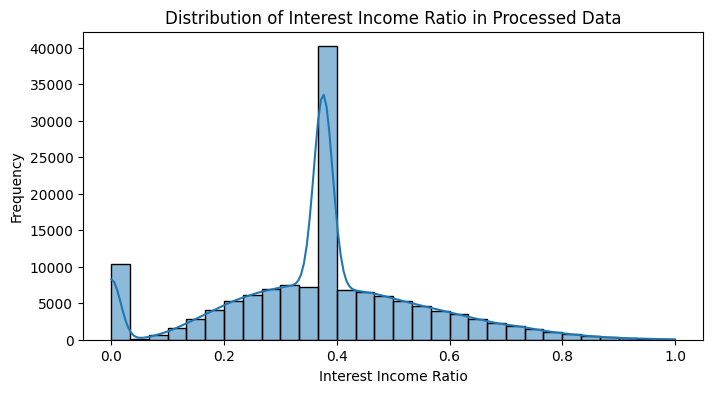

In [15]:
# Plot the distribution of the interest_income_ratio feature
plt.figure(figsize=(8, 4))
sns.histplot(data_processed['interest_income_ratio'], kde=True, bins=30)
plt.title("Distribution of Interest Income Ratio in Processed Data")
plt.xlabel("Interest Income Ratio")
plt.ylabel("Frequency")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Define X and y for the model
X = data_processed.drop(columns=['Status'])
y = data_processed['Status']

# Train a RandomForest model to get feature importances
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display features with lowest importance
print("Least important features:")
print(feature_importances.tail(25))

Least important features:
                 Feature    Importance
73        total_units_3U  1.500492e-05
53            term_336.0  1.487097e-05
54            term_348.0  1.156248e-05
34            term_144.0  9.837953e-06
74        total_units_4U  9.363677e-06
35            term_156.0  8.570246e-06
95  Security_Type_direct  7.678325e-06
33            term_132.0  6.724188e-06
70       Secured_by_land  6.500056e-06
50            term_312.0  6.204413e-06
48            term_288.0  5.252054e-06
57              term_nan  5.208393e-06
45            term_264.0  4.592325e-06
64  construction_type_mh  4.351758e-06
42            term_228.0  3.681918e-06
46            term_276.0  3.565386e-06
37            term_168.0  2.907145e-06
41            term_216.0  2.867401e-06
39            term_192.0  2.313701e-06
40            term_204.0  2.287379e-06
31            term_108.0  1.826618e-06
44            term_252.0  2.930267e-07
51            term_322.0  0.000000e+00
36            term_165.0  0.000000e+00

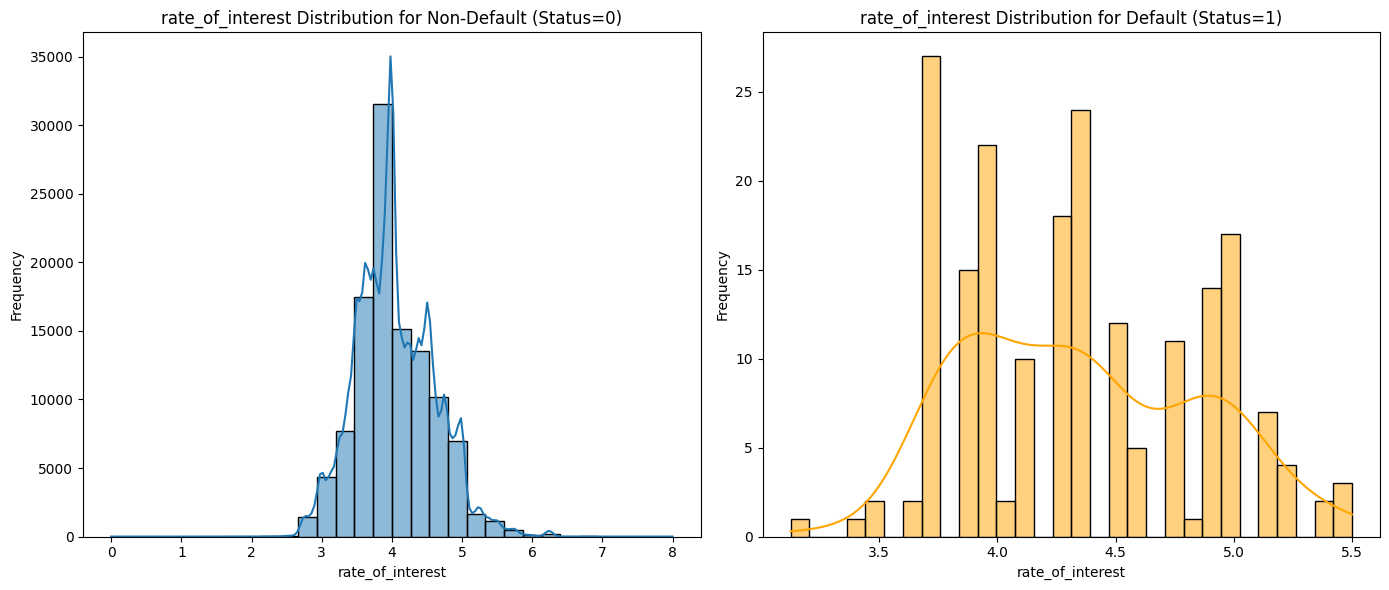

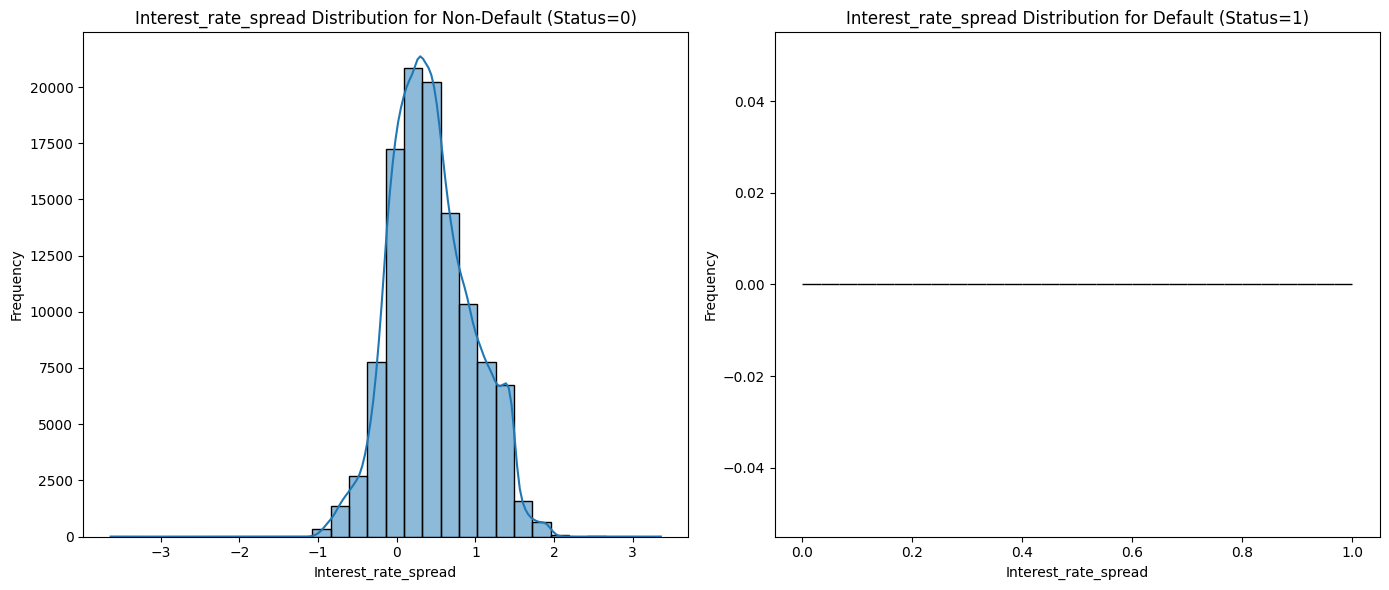

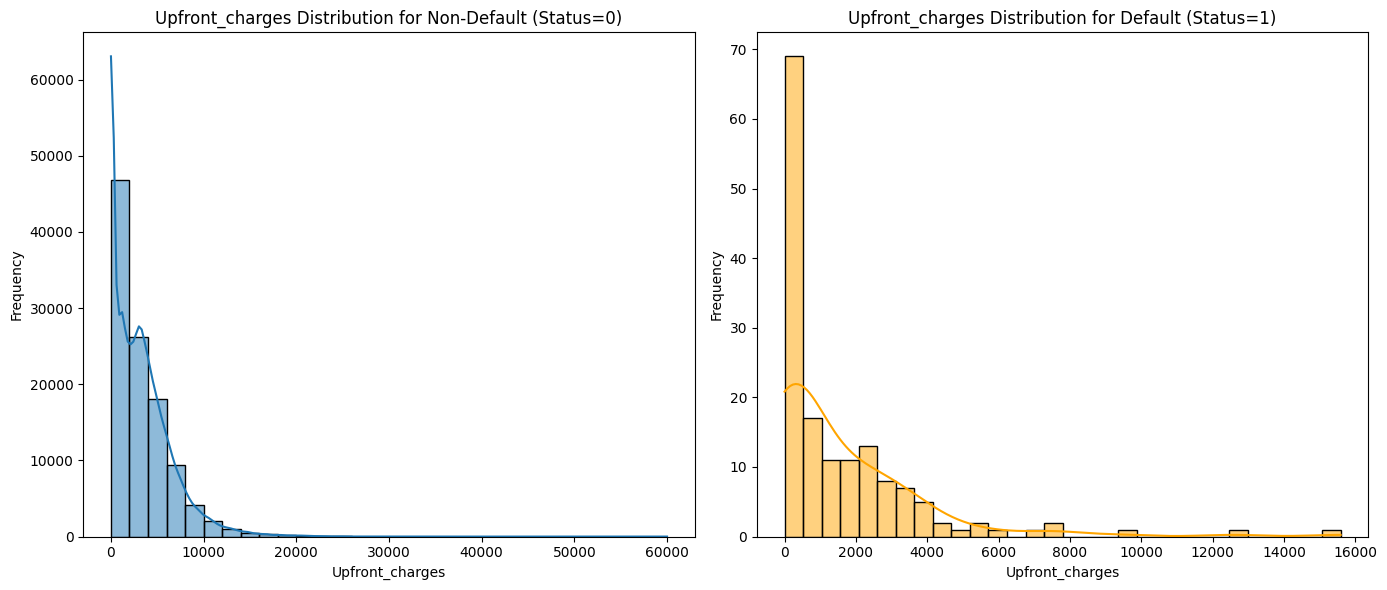

In [17]:
# List of variables to investigate
variables_to_check = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']

# Separate data by Status (Default = 1 and Non-Default = 0)
default_data = data[data['Status'] == 1]
non_default_data = data[data['Status'] == 0]

# Plot distributions for each variable by Status
for var in variables_to_check:
    plt.figure(figsize=(14, 6))

    # Distribution for Non-Default Status (0)
    plt.subplot(1, 2, 1)
    sns.histplot(non_default_data[var], kde=True, bins=30)
    plt.title(f'{var} Distribution for Non-Default (Status=0)')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Distribution for Default Status (1)
    plt.subplot(1, 2, 2)
    sns.histplot(default_data[var], kde=True, bins=30, color='orange')
    plt.title(f'{var} Distribution for Default (Status=1)')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

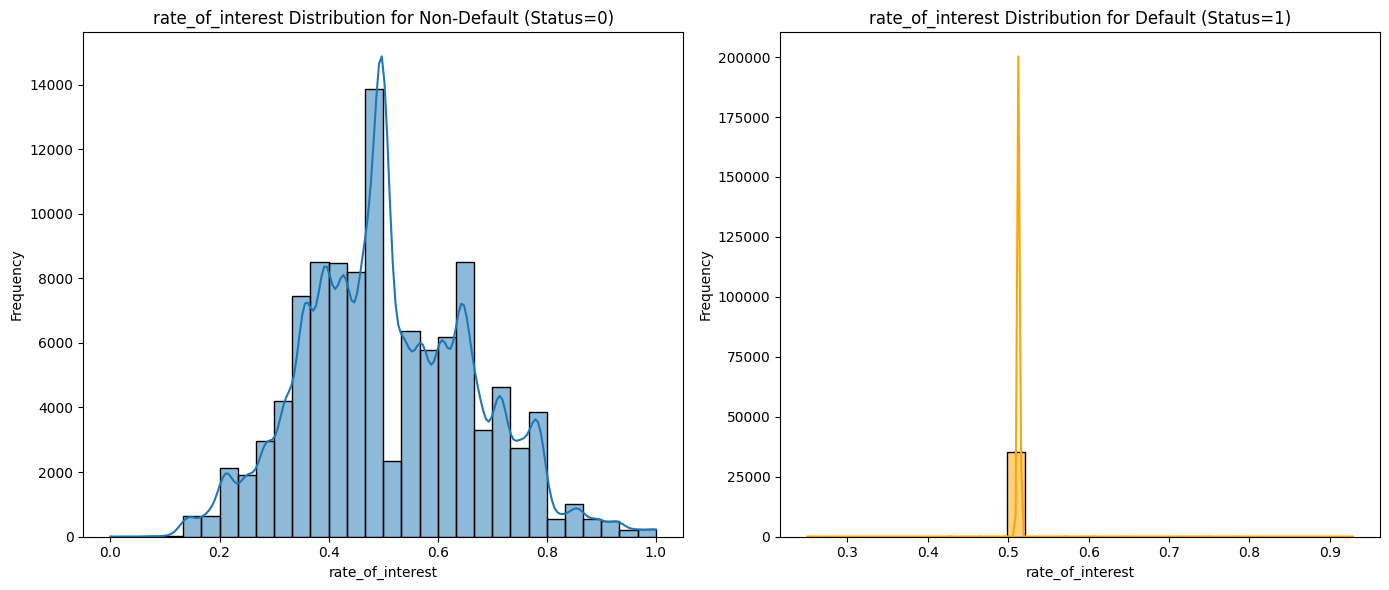

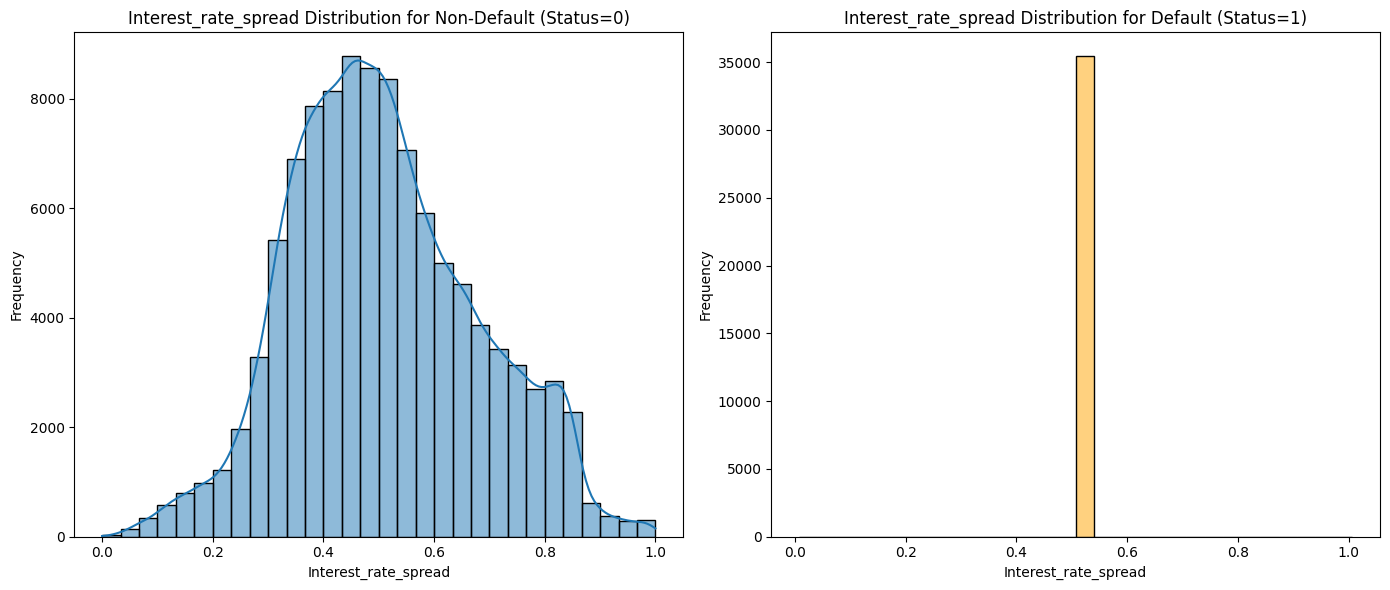

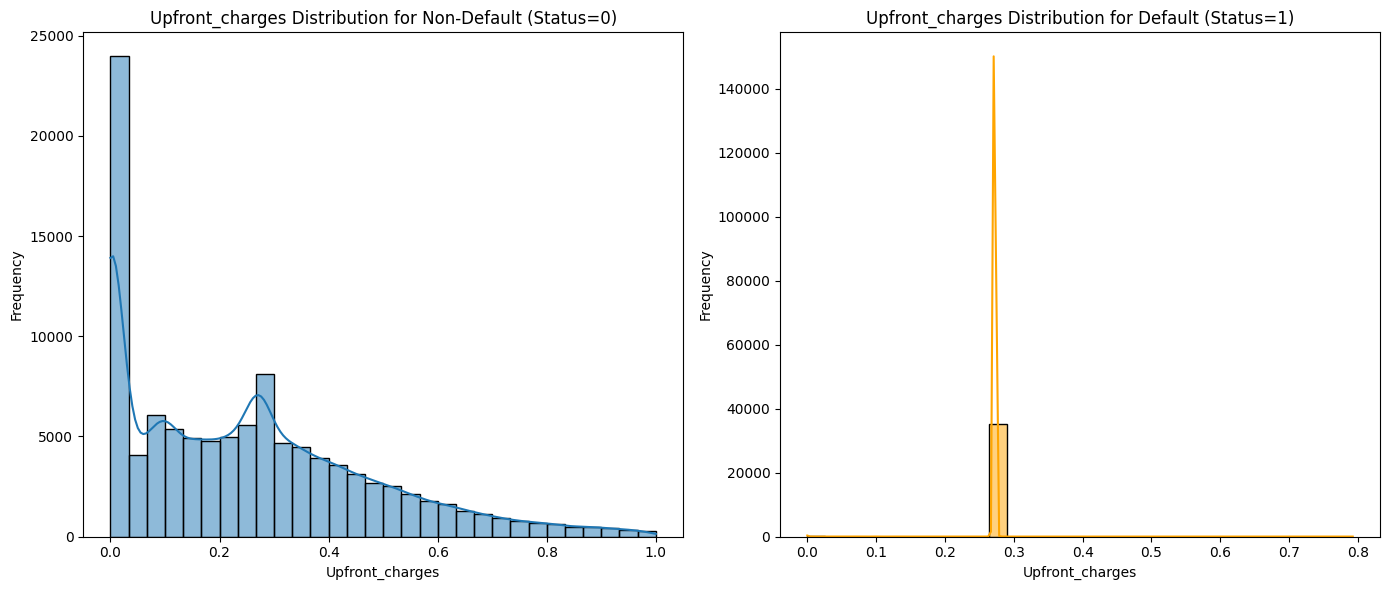

In [18]:
# List of variables to investigate
variables_to_check = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']

# Separate data by Status (Default = 1 and Non-Default = 0)
default_data = data_processed[data_processed['Status'] == 1]
non_default_data = data_processed[data_processed['Status'] == 0]

# Plot distributions for each variable by Status
for var in variables_to_check:
    plt.figure(figsize=(14, 6))

    # Distribution for Non-Default Status (0)
    plt.subplot(1, 2, 1)
    sns.histplot(non_default_data[var], kde=True, bins=30)
    plt.title(f'{var} Distribution for Non-Default (Status=0)')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Distribution for Default Status (1)
    plt.subplot(1, 2, 2)
    sns.histplot(default_data[var], kde=True, bins=30, color='orange')
    plt.title(f'{var} Distribution for Default (Status=1)')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# 4. Prepare the Data for Modeling

In [34]:
# Define target variable and features
target_column = 'Status'
X = data_processed.drop(columns=[target_column])
y = data_processed[target_column]

In [35]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Check target distribution
print("Training set target distribution:")
print(y_train.value_counts())

print("Test set target distribution:")
print(y_test.value_counts())

Training set target distribution:
Status
0.0    84741
1.0    28411
Name: count, dtype: int64
Test set target distribution:
Status
0.0    21266
1.0     7023
Name: count, dtype: int64


Distribution of Status:
Status
0.0    74.947858
1.0    25.052142
Name: proportion, dtype: float64

Summary statistics by Status (mean):
        loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
Status                                                                         
0.0        0.269021          0.512124              0.508138         0.252476   
1.0        0.251846          0.513479              0.506896         0.271623   

        property_value    income  Credit_Score       LTV     dtir1  \
Status                                                               
0.0           0.305878  0.313399      0.498673  0.491373  0.582311   
1.0           0.289902  0.265920      0.501642  0.509164  0.605392   

        loan_limit_cf  ...   age_<25   age_>74  \
Status                 ...                       
0.0          0.947070  ...  0.008726  0.044488   
1.0          0.923633  ...  0.010724  0.058390   

        submission_of_application_not_inst  submission_of_app

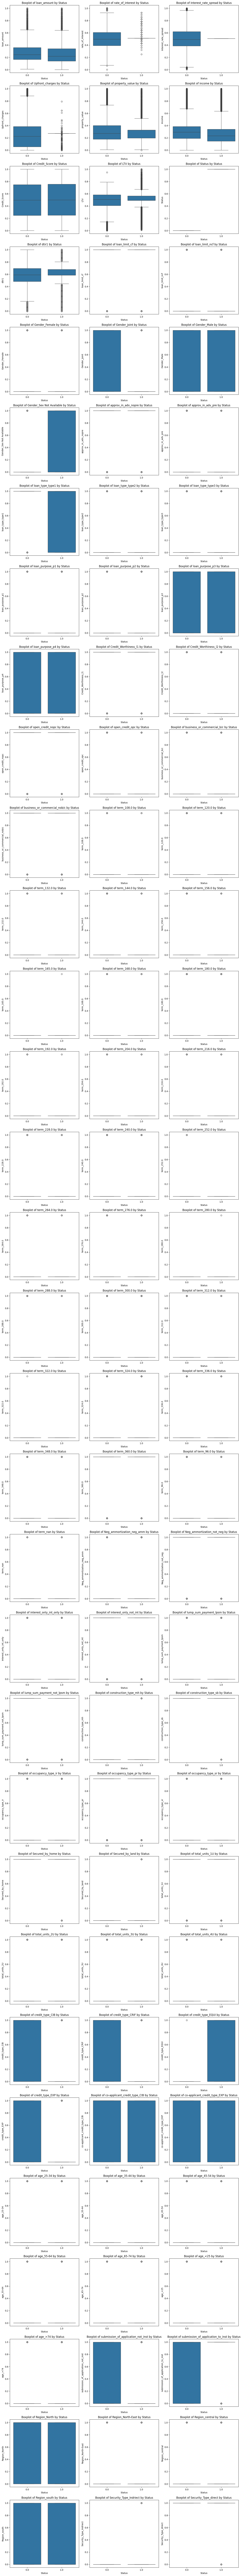

<Figure size 1500x0 with 0 Axes>

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# 1. Distribution of the target variable `Status`
print("Distribution of Status:")
print(data_processed['Status'].value_counts(normalize=True) * 100)

# 2. Summary statistics for numerical variables by `Status`
print("\nSummary statistics by Status (mean):")
print(data_processed.groupby('Status').mean())

# 3. Additional statistical measures like median and standard deviation
print("\nMedian by Status:")
print(data_processed.groupby('Status').median())
print("\nStandard deviation by Status:")
print(data_processed.groupby('Status').std())

# 4. Visualization: Boxplots for numerical variables
numeric_columns = data_processed.select_dtypes(include=['float64', 'int64']).columns
num_numeric_columns = len(numeric_columns)
num_rows = math.ceil(num_numeric_columns / 3)

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.boxplot(x='Status', y=col, data=data_processed)  # Use data_processed here
    plt.title(f'Boxplot of {col} by Status')
plt.tight_layout()
plt.show()

# 5. Visualization: Countplots for categorical variables
categorical_columns = data_processed.select_dtypes(include=['object']).columns
num_categorical_columns = len(categorical_columns)
num_rows = math.ceil(num_categorical_columns / 3)

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.countplot(x=col, hue='Status', data=data_processed)
    plt.title(f'Countplot of {col} by Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Model Selection and Initial Tests

**Why is Recall particularly important?**


In loan default prediction, the goal is to identify loans that might default (class `1`) so that actions can be taken, such as conducting additional checks or setting stricter requirements for these applicants. Recall for the default class (class `1`) is crucial here because:
1. Recall measures the model's ability to detect actual defaults: A high recall value means the model is capturing a large portion of true defaults, reducing the risk of "false negatives" (loans that default but are predicted as safe).
2. Minimizing costs and risks: False negatives can be costly for a bank or lending institution, as undetected defaults could lead to significant financial losses. Recall helps mitigate this risk.

**How does Recall differ from Precision?**


1. Recall: Measures the proportion of actual defaults that were correctly identified by the model. It answers the question: How many of the true defaults did the model detect?
2. Precision: Measures the proportion of predicted defaults that are actual defaults. It answers: How reliable are the default predictions?
While Precision is also valuable, in this case, it's often more desirable to have a model that over-identifies defaults rather than misses them (higher Recall).

**Models that are suitable for high Recall**
1. Random Forest
2. Gradient Boosting 
3. Logistic Regression
4. Support Vector Machines
5. Naive Bayes

Checking the target distribution helps us to make an informed decision about the balancing strategy and to ensure that our model is trained and tested fairly. Depending on the distribution, we then decide whether a simple balancing or a stronger adjustment (e.g. SMOTE) is necessary.

In [39]:
data = data_processed

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define target variable and features
target_column = 'Status'  # Target column for loan default prediction
X = data.drop(columns=[target_column])
y = data[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check target distribution in the full dataset, training set, and test set
print("Full dataset target distribution:")
print(y.value_counts(normalize=True) * 100)

print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set target distribution:")
print(y_test.value_counts(normalize=True) * 100)


Full dataset target distribution:
Status
0.0    74.947858
1.0    25.052142
Name: proportion, dtype: float64

Training set target distribution:
Status
0.0    74.891297
1.0    25.108703
Name: proportion, dtype: float64

Test set target distribution:
Status
0.0    75.174096
1.0    24.825904
Name: proportion, dtype: float64


To start with, use class_weight='balanced' in the models. This is a straightforward approach and should be sufficient for this type of distribution. 

# 3. Create Baseline Model

In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Function to evaluate model using Cross-Validation with fewer folds
def evaluate_model_cv(model, X, y, cv=3):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

# Dictionary to store results
results_cv = {}

# Evaluate each model using Cross-Validation
for model_name, model in models.items():
    print(f"Evaluating {model_name} with Cross-Validation...")
    metrics_cv = evaluate_model_cv(model, X_train, y_train, cv=3)
    results_cv[model_name] = metrics_cv
    print(f"{model_name} Cross-Validation Metrics: {metrics_cv}\n")

# Display Cross-Validation results in a DataFrame
results_cv_df = pd.DataFrame(results_cv).T
print("Cross-Validated Model Performance:")
print(results_cv_df)


Evaluating Random Forest with Cross-Validation...
Random Forest Cross-Validation Metrics: {'Accuracy': np.float64(1.0), 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1 Score': np.float64(1.0)}

Evaluating Gradient Boosting with Cross-Validation...
Gradient Boosting Cross-Validation Metrics: {'Accuracy': np.float64(0.9999911622522116), 'Precision': np.float64(0.9999648048428537), 'Recall': np.float64(1.0), 'F1 Score': np.float64(0.9999824014923534)}

Evaluating Logistic Regression with Cross-Validation...
Logistic Regression Cross-Validation Metrics: {'Accuracy': np.float64(0.8377050167284826), 'Precision': np.float64(0.675880998223222), 'Recall': np.float64(0.6794549923995928), 'F1 Score': np.float64(0.677659888138423)}

Evaluating Naive Bayes with Cross-Validation...
Naive Bayes Cross-Validation Metrics: {'Accuracy': np.float64(0.8732236186108974), 'Precision': np.float64(0.9999288053538374), 'Recall': np.float64(0.4951249727256115), 'F1 Score': np.float64(0.6622970580517

# 4. Model Comparison

# 5. Model Optimization (hyperparameter tuning)

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for tuning Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Set up GridSearchCV for Logistic Regression with class balancing and a focus on maximizing recall
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='recall'
)

# Fit GridSearchCV on the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

Best parameters: {'C': 10, 'solver': 'liblinear'}
Best Recall: 0.6807928547834947


In [43]:
from sklearn.metrics import classification_report

# Retrieve prediction probabilities for the positive class (1)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Set a custom threshold for classifying as positive
threshold = 0.3
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# Calculate metrics for the adjusted predictions
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

         0.0       0.92      0.57      0.71     21266
         1.0       0.40      0.84      0.54      7023

    accuracy                           0.64     28289
   macro avg       0.66      0.71      0.62     28289
weighted avg       0.79      0.64      0.66     28289



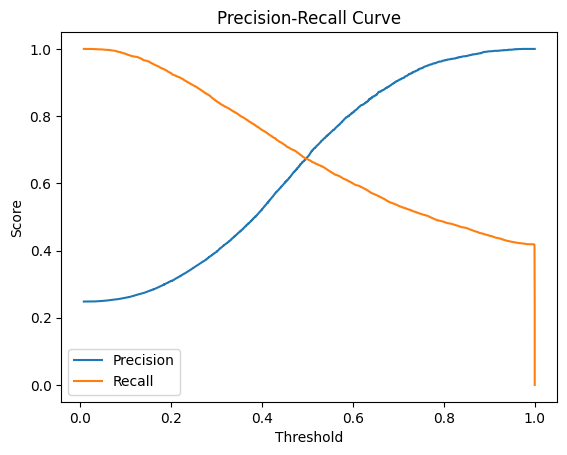

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Obtain predicted probabilities for the positive class (1)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall values across different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot precision and recall as functions of the threshold
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Set threshold to 0.5 and calculate metrics
threshold = 0.5
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)  # Adjusted predictions with threshold 0.5

# Calculate metrics for threshold 0.5
print(f"Metrics for threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("Precision:", precision_score(y_test, y_pred_adjusted))
print("Recall:", recall_score(y_test, y_pred_adjusted))
print("F1 Score:", f1_score(y_test, y_pred_adjusted))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Optional: Calculate metrics for various thresholds in the range 0.44 - 0.5
thresholds = [0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_prob >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    print(f"\nMetrics for threshold {thresh}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Metrics for threshold 0.5:
Accuracy: 0.8392307964226378
Precision: 0.6777251184834123
Recall: 0.6719350704826997
F1 Score: 0.6748176748176749

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     21266
         1.0       0.68      0.67      0.67      7023

    accuracy                           0.84     28289
   macro avg       0.78      0.78      0.78     28289
weighted avg       0.84      0.84      0.84     28289


Metrics for threshold 0.44:
Precision: 0.5851578704770685
Recall: 0.7230528264274526
F1 Score: 0.6468377810330552

Metrics for threshold 0.45:
Precision: 0.6002152595072949
Recall: 0.7146518581802649
F1 Score: 0.6524536886577835

Metrics for threshold 0.46:
Precision: 0.6155660377358491
Recall: 0.7061085006407518
F1 Score: 0.6577359241329

Metrics for threshold 0.47:
Precision: 0.632800412583806
Recall: 0.6988466467321658
F1 Score: 0.6641856688544556

Metrics for threshold 0.48:
Precision: 0.647522372

# 6. Model Selection and Evaluation

# 7. Saving the Best Model